# 1. The frequency factor

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

## 1.1 The value of K

From McKeever's equation for the frequency factor:
$$ S = \nu_{ph} ~ K ~ e^{\frac{\Delta S}{k_B}} $$

For the known values from `ParametrosCineticos.xlsx` of $s$, and taking the value of $\nu_{ph}$ of the LiF, solving for $K$ yields:

$$ \nu_{ph} = \frac{s}{ e^{\left(\Delta S /k_B \right) }}$$

In [6]:
# Constants
kB = 8.617e-5                # (eV/K)
nu_m = 90000                 # from the Bransden book (m-1)
nu_s = 2.9979e8 * nu_m       # (s-1)
delta_S = 1.5 * kB           # (eV/K)

PathCinetics = 'ExperimentalData/ParametrosCineticos.xlsx'
CineticsData = pd.read_excel(PathCinetics, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

S = [CineticsData.iloc[i, 1] for i in range(6)]                            # Frequency factor for trap i (s-1)
S_R_h, S_NR_h = CineticsData.iloc[0, 3], CineticsData.iloc[0, 5]           # Frequency factor for radiative/ non radiative recombination centers (s-1)
S_all = S + [S_R_h, S_NR_h]  # Flatten S_all into a single list of scalar values

# Mean frequency factor
S_mean = np.mean(S_all)
K_mean = S_mean / (np.exp(delta_S / kB))

# Value of K
K = np.zeros(len(S_all))
names = ['I', 'II', 'III', 'IV', 'V', 's', 'R', 'NR']
for i in range(len(S_all)):
    K[i] = S_all[i] / (np.exp(delta_S / kB))
    print(f"Value of K for trap {names[i]}: {K[i]:.2e} s-1")

print(f"Value of K: {K_mean:.2e} s-1")
nu_m = 90000                # from B.H. Bransden book (m-1)
nu_s = 2.9979e8 * nu_m      # (s-1)
print(f"Value of nu_s: {nu_s:.2e} s-1")


Value of K for trap I: 2.23e+14 s-1
Value of K for trap II: 3.15e+13 s-1
Value of K for trap III: 2.02e+15 s-1
Value of K for trap IV: 1.29e+15 s-1
Value of K for trap V: 1.94e+17 s-1
Value of K for trap s: 2.23e+14 s-1
Value of K for trap R: 2.23e+15 s-1
Value of K for trap NR: 2.23e+15 s-1
Value of K: 2.53e+16 s-1
Value of nu_s: 2.70e+13 s-1


## 1.2 Experimental entropy factor

- `excel`: ParametrosCineticos.xlsx
- `ref1`: 9 - Simulation of the experimental thermal cleaning procedure in LiF-Mg,Ti

In [7]:
# values and references
E_excel = np.array([1.19, 1.38, 1.68, 1.78, 2.12, 3.00, 2.30, 2.30])
s_excel = np.array([1.00e15, 1.41e14, 9.05e15, 5.78e15, 8.71e17, 1.00e15, 1.00e16, 1.00e16])

E_ref1 = np.array([1.5, 1.78, 2.13])
s_ref1 = np.array([6.7657e13, 6.7619e16, 2.9178e19])
T_ref1 = np.array([451.5, 482.8, 511.5])

B = np.zeros(len(E_ref1)) + 1.59095
kB = 8.617e-5  # (eV/K)
#t_teorical = E_ref1 / (B * kB * )

# Plot



Another take, fixing the values of the entropy increment

In [8]:
# values and references
E_excel = np.array([1.19, 1.38, 1.68, 1.78, 2.12, 3.00, 2.30, 2.30])
s_excel = np.array([1.00e15, 1.41e14, 9.05e15, 5.78e15, 8.71e17, 1.00e15, 1.00e16, 1.00e16])

nu_m = 90000                 # from the Bransden book (m-1)
nu_s = 2.9979e8 * nu_m       # (s-1)
deltaS_excel = kB * np.log(s_excel / (nu_s * K_mean))
print(f"deltaS_excel: {deltaS_excel}")

deltaS_excel: [-0.00294339 -0.0031122  -0.00275358 -0.00279221 -0.00236005 -0.00294339
 -0.00274497 -0.00274497]


# Plots

## 2.1 Effect of irradiation

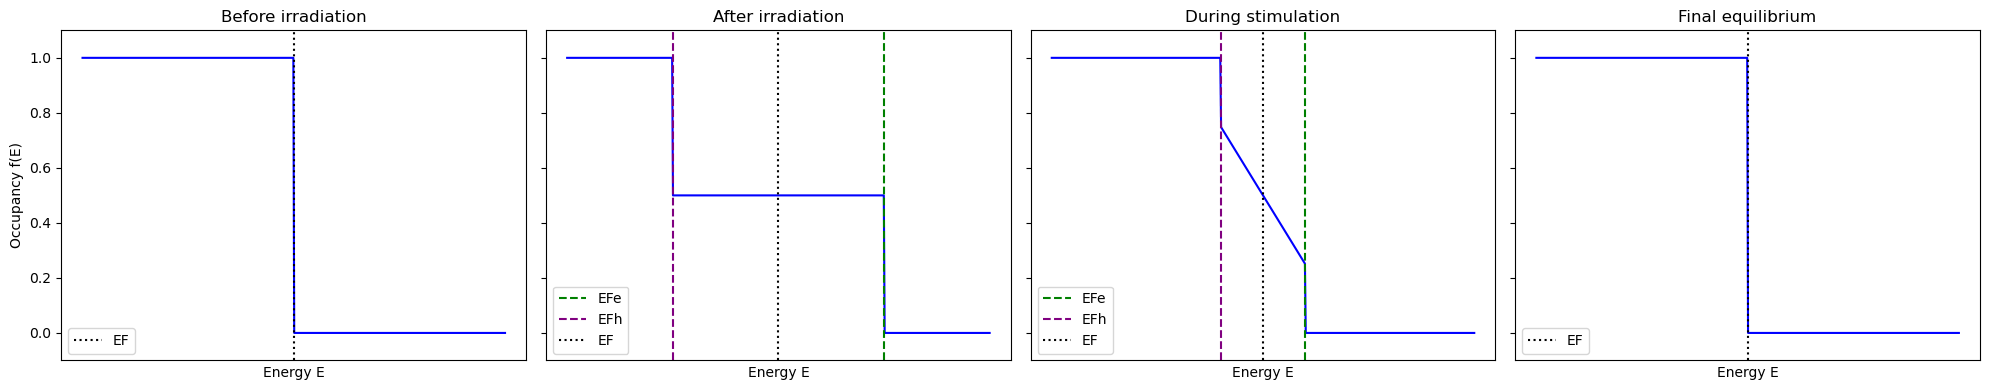

In [9]:
## FOR THE CASE OF THE STEP FUNCTION T = 0 K
# Energy range
E = np.linspace(-1, 1, 500)

# Fermi-Dirac distribution at 0 K
def fermi_0K(E, Ef):
    return np.where(E < Ef, 1, 0)

# State inmediately before irradiation: definition of the quasi-Fermi level
def irradiated_occupancy_0K(E, Ef, Efe, Efh):
    f = np.zeros_like(E)
    f[E < Efh] = 1
    f[(Efh <= E) & (E <= Efe)] = 0.5  # partial occupation (idealized)
    return f

# State during irradiation: smooth transition between EFe and EFh
def stimulated_occupancy_0K(E, Ef, Efe, Efh):
    f = np.zeros_like(E)
    mask = (Efh <= E) & (E <= Efe)
    f[E < Efh] = 1
    f[mask] = 0.75 - 0.5 * (E[mask] - Efh) / (Efe - Efh)  # lineal transition
    return f

# Level definitions
Ef = 0.0                 # original Fermi level
Efe_initial = 0.5
Efh_initial = -0.5
Efe_mid = 0.2
Efh_mid = -0.2

# Functions for plotting
f_before = fermi_0K(E, Ef)
f_after = irradiated_occupancy_0K(E, Ef, Efe_initial, Efh_initial)
f_during = stimulated_occupancy_0K(E, Ef, Efe_mid, Efh_mid)
f_final = fermi_0K(E, Ef)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
titles = ['Before irradiation', 'After irradiation', 'During stimulation', 'Final equilibrium']
occupancies = [f_before, f_after, f_during, f_final]
labels = ['EF', (Efe_initial, Efh_initial), (Efe_mid, Efh_mid), 'EF']

for i in range(4):
    axs[i].plot(E, occupancies[i], color='blue' if i == 1 else 'blue')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Energy E')
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xticks([])

    # Vertical lines for Fermi levels
    if i == 1 or i == 2:
        Efe, Efh = labels[i]
        axs[i].axvline(Efe, color='green', linestyle='--', label='EFe')
        axs[i].axvline(Efh, color='purple', linestyle='--', label='EFh')
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')
        axs[i].legend(loc='lower left')
    else:
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')
        axs[i].legend(loc='lower left')

    if i == 0:
        axs[i].set_ylabel('Occupancy f(E)')

axs[0].legend(loc='lower left')
plt.tight_layout()
plt.show()


/var/folders/_c/s9xtx7kn61l5wvpw4pyjsc8c0000gn/T/ipykernel_79553/1888179194.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((E - Ef) / (kB * T)))


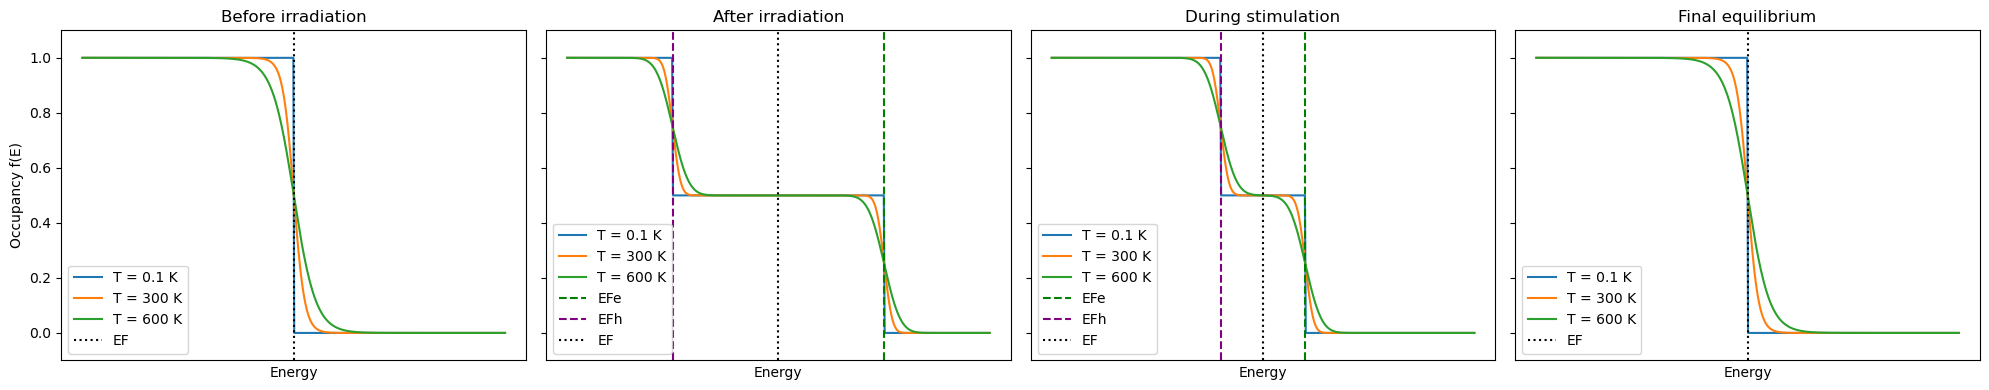

In [10]:
## FOR THE CASE OF A NON ZERO TEMPERATURE

# Energy and temperature range
E = np.linspace(-1, 1, 500)
Ts = [0.1, 300, 600]  # K

# Fermi-Dirac distribution at T > 0 K
def fermi_T(E, Ef, T):
    kB = 8.617e-5  # eV/K
    return 1 / (1 + np.exp((E - Ef) / (kB * T)))

# State during irradiation: smooth transition between EFe and EFh
def irradiated_occupancy_T_temp(E, Efe, Efh, T):
    """
    Constructs a piecewise occupancy function with smoothing based on temperature.
    Sharp at low T, smooth at high T. Matches visual expectation.
    """
    f = np.zeros_like(E)
    f[E < Efh] = 1
    f[(E >= Efh) & (E <= Efe)] = 0.5
    f[E > Efe] = 0

    # Smooth with Gaussian kernel whose width depends on T
    sigma = T / 40  # Empirical smoothing factor
    return gaussian_filter1d(f, sigma=sigma)

# Level definitions
Ef = 0.0                 # original Fermi level
Efe_initial = 0.5
Efh_initial = -0.5
Efe_mid = 0.2
Efh_mid = -0.2

# Temperatures
T = 300  # K
f_before = np.zeros((len(Ts), len(E)))
f_after = np.zeros((len(Ts), len(E)))
f_during = np.zeros((len(Ts), len(E)))
f_final = np.zeros((len(Ts), len(E)))

# Functions for plotting
for t in range(len(Ts)):
    f_before[t] = fermi_T(E, Ef, Ts[t])
    f_after[t] = irradiated_occupancy_T_temp(E, Efe_initial, Efh_initial, Ts[t])
    f_during[t] = irradiated_occupancy_T_temp(E, Efe_mid, Efh_mid, Ts[t])
    f_final[t] = fermi_T(E, Ef, Ts[t])

    # Plot the curves for each temperature in the for loop

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
titles = ['Before irradiation', 'After irradiation', 'During stimulation', 'Final equilibrium']
occupancies = [f_before, f_after, f_during, f_final]
labels = ['EF', (Efe_initial, Efh_initial), (Efe_mid, Efh_mid), 'EF']

for i in range(4):
    for t in range(len(Ts)):
        axs[i].plot(E, occupancies[i][t], label=f'T = {Ts[t]} K')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Energy')
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xticks([])

    # Vertical lines for Fermi levels
    if i == 1 or i == 2:
        Efe, Efh = labels[i]
        axs[i].axvline(Efe, color='green', linestyle='--', label='EFe')
        axs[i].axvline(Efh, color='purple', linestyle='--', label='EFh')
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')
    else:
        axs[i].axvline(Ef, color='black', linestyle=':', label='EF')

    if i == 0:
        axs[i].set_ylabel('Occupancy f(E)')
    axs[i].legend(loc='lower left')
plt.tight_layout()

# Save image to 'Images' folder
fig.savefig('LaTeX/Images/FD_irradiation.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Frequency Factor

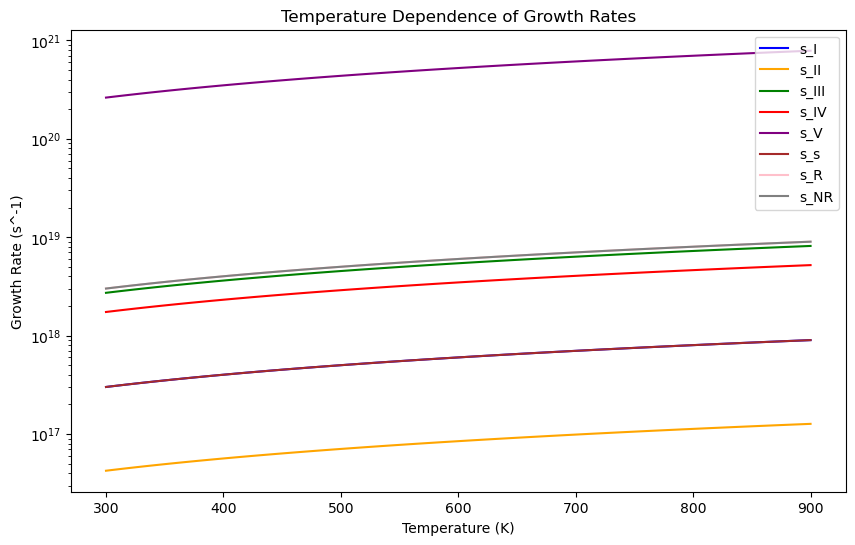

In [11]:
# Temperature vector
T = np.linspace(300, 900, 100)  # K
#T = 273.15  # K

# Frequency factor with temperature
growth = 1
hr = 0
npoints = 100
time = np.linspace(0, npoints-1, npoints)

s_I = s_excel[0] * (1 + growth * (T + hr * time))
s_II = s_excel[1] * (1 + growth * (T + hr * time))
s_III = s_excel[2] * (1 + growth * (T + hr * time))
s_IV = s_excel[3] * (1 + growth * (T + hr * time))
s_V = s_excel[4] * (1 + growth * (T + hr * time))
s_s = s_excel[5] * (1 + growth * (T + hr * time))
s_R = s_excel[6] * (1 + growth * (T + hr * time))
s_NR = s_excel[7] * (1 + growth * (T + hr * time))

# Plotting
#T = hr * time + T
plt.figure(figsize=(10, 6))
plt.plot(T, s_I, label='s_I', color='blue')
plt.plot(T, s_II, label='s_II', color='orange')
plt.plot(T, s_III, label='s_III', color='green')
plt.plot(T, s_IV, label='s_IV', color='red')
plt.plot(T, s_V, label='s_V', color='purple')
plt.plot(T, s_s, label='s_s', color='brown')
plt.plot(T, s_R, label='s_R', color='pink')
plt.plot(T, s_NR, label='s_NR', color='gray')
plt.title('Temperature Dependence of Growth Rates')
plt.xlabel('Temperature (K)')
plt.yscale('log')
plt.ylabel('Growth Rate (s^-1)')
plt.legend()
plt.show()


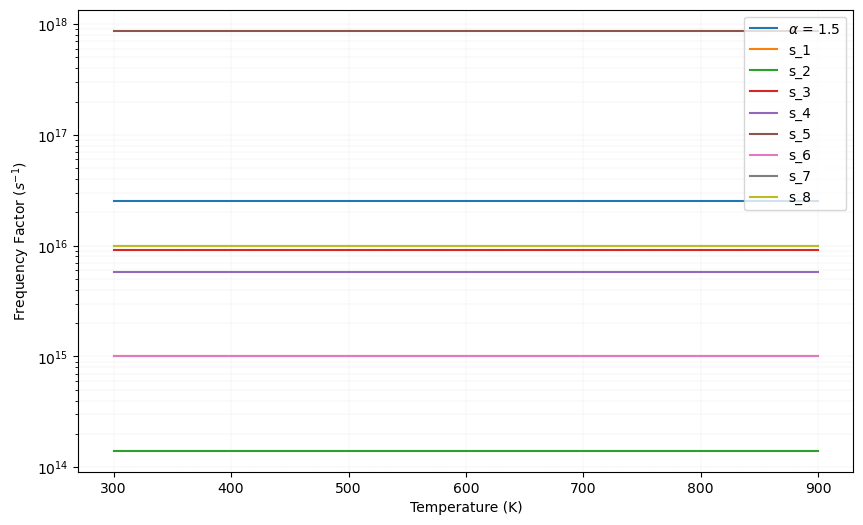

In [ ]:
from matplotlib.ticker import ScalarFormatter
from Functions.freq_factor import freq_factor

kB = 8.617e-5  # eV/K
#deltaS = (1.5 * kB) / np.log(300) * kB * np.log(T)

s_freqfactor2 = freq_factor((1.5 * kB) / np.log(300) * kB * np.log(T))

plt.figure(figsize=(10, 6))
plt.plot(T, s_freqfactor2, label=r'$\alpha$ = 1.5')
for i in range(len(S_all)):
    plt.plot(T, np.ones_like(T) * s_excel[i], label=f's_{i+1}')
plt.xlabel('Temperature (K)')
plt.ylabel(r'Frequency Factor $(s^{-1})$')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.legend()
plt.show()